<a href="https://colab.research.google.com/github/dslrsiddesh/biometrics-project/blob/main/biometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = '/content/drive/MyDrive/tbnd_v2/'

### Import Libraries

In [5]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

### Required functions

In [6]:
import os
import cv2

def load_images(folder_path, sub_directory):
    images = []  # List to store image data
    labels = []  # List to store labels

    # Construct the full path to the subdirectory
    sub_dir_path = os.path.join(folder_path, sub_directory)

    # Check if the subdirectory exists
    if not os.path.exists(sub_dir_path):
        print("Subdirectory does not exist.")
        return images, labels  # Return empty lists if the subdirectory does not exist

    print(f'loading image files from {sub_directory}.')

    # Iterate over each file in the subdirectory
    for filename in os.listdir(sub_dir_path):
        filepath = os.path.join(sub_dir_path, filename)  # Construct the full file path

        if os.path.isfile(filepath):  # Check if the path is a file
            img = cv2.imread(filepath)  # Read the image file
            if img is not None:  # Check if the image was successfully read
                img = cv2.resize(img, (300, 300))  # Resize the image to 300x300 pixels
                images.append(img)  # Add the image to the list
                label_name = filename.split('.')[0]  # Extract the label from the filename
                labels.append(label_name)  # Add the label to the list

    print('images loaded and scaled.')
    return images, labels  # Return the lists of images and labels

In [7]:
def plot_image(img = None, file_path = None, title = None):
  if file_path:
    img = cv2.imread(file_path)
  print("Image Shape :", img.shape)
  plt.figure(figsize=(2, 2))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(f'Subject-{title}')
  plt.show()

Image Shape : (483, 483, 3)


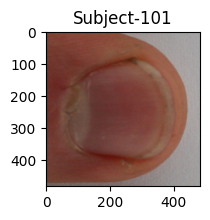

In [8]:
plot_image(img=None, file_path=folder_path + 'D1/101.jpg', title='101')

## Preprocessing

### Scale down all images to 300pixels x 300pixels

In [9]:
d1_images, d1_labels = load_images(folder_path, 'D1')

loading image files from D1.
images loaded and scaled.


In [10]:
print(len(d1_images), d1_images[0].shape)

93 (300, 300, 3)


Image Shape : (300, 300, 3)


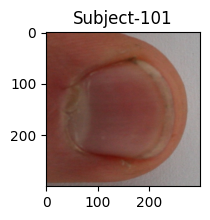

In [11]:
plot_image(img = d1_images[0], file_path = None, title = d1_labels[0])

## Feature Extraction

### LBP Based Signature Extraction

In [12]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def lbp_signature_extraction(image):
    # Parameters for LBP
    P, R = 8, 2
    method = 'uniform'

    # Define block size for dividing the image into 16 blocks using a 4x4 grid
    block_size = 4
    block_height = image.shape[0] // block_size
    block_width = image.shape[1] // block_size

    histograms = []  # List to store histograms for each block and pyramid level
    for i in range(3):  # Iterate over each color channel (assuming the image is RGB)
        color_channel = image[:, :, i]  # Extract the i-th color channel
        for r in range(block_size):  # Iterate over each block row
            for c in range(block_size):  # Iterate over each block column
                # Extract the block from the color channel
                block = color_channel[r*block_height:(r+1)*block_height, c*block_width:(c+1)*block_width]

                # Create a list to hold the Gaussian pyramid images for the block
                pyramid_images = [block]
                for _ in range(2):  # Create two levels of Gaussian pyramid
                    block = cv2.pyrDown(block)  # Downsample the image
                    pyramid_images.append(block)

                # Apply LBP and compute histograms for each pyramid image
                for pyr_image in pyramid_images:
                    # Compute LBP for the pyramid image
                    lbp = local_binary_pattern(pyr_image, P, R, method)
                    # Compute histogram of LBP
                    hist = np.histogram(lbp, bins=59, range=(0, 59), density=True)[0]
                    histograms.append(hist)  # Append the histogram to the list

    return histograms  # Return the list of histograms

In [13]:
print(len(lbp_signature_extraction(d1_images[0])))

144


### Descriptor Based Siganature Extraction (SIFT & BRISK)

In [14]:
import cv2
import numpy as np

def compute_descriptors(image):
    # Split the image into its B, G, R channels
    b, g, r = cv2.split(image)
    channels = [b, g, r]

    # Initialize the GFTT detector
    gftt = cv2.GFTTDetector_create()

    # Lists to store keypoints and descriptors for SIFT and BRISK
    all_keypoints_sift = []
    all_keypoints_brisk = []
    descriptors_sift = []
    descriptors_brisk = []

    # Loop over each color channel
    for channel in channels:
        # Detect keypoints using the GFTT detector
        keypoints = gftt.detect(channel, None)

        # Initialize the SIFT detector
        sift = cv2.xfeatures2d.SIFT_create()
        # Compute SIFT descriptors for the keypoints
        keypoints_sift, sift_descriptors = sift.compute(channel, keypoints)
        # Add SIFT keypoints and descriptors to the lists
        all_keypoints_sift.extend(keypoints_sift)
        descriptors_sift.extend(sift_descriptors)

        # Initialize the BRISK detector
        brisk = cv2.BRISK_create()
        # Compute BRISK descriptors for the keypoints
        keypoints_brisk, brisk_descriptors = brisk.compute(channel, keypoints)
        # Add BRISK keypoints and descriptors to the lists
        all_keypoints_brisk.extend(keypoints_brisk)
        descriptors_brisk.extend(brisk_descriptors)

    # Convert lists to numpy arrays
    all_keypoints_sift = np.array(all_keypoints_sift)
    descriptors_sift = np.array(descriptors_sift)
    all_keypoints_brisk = np.array(all_keypoints_brisk)
    descriptors_brisk = np.array(descriptors_brisk)

    return all_keypoints_sift, descriptors_sift, all_keypoints_brisk, descriptors_brisk


In [15]:
keypoints_sift, descriptors_sift, keypoints_brisk, descriptors_brisk = compute_descriptors(d1_images[0])
print("SIFT Keypoints :", len(keypoints_sift))
print("SIFT Desriptors :", len(descriptors_sift))
print("BRISK Keypoints :", len(keypoints_brisk))
print("BRISK Desriptors :", len(descriptors_brisk))

print(keypoints_sift.shape)
print(descriptors_sift.shape)
print(keypoints_brisk.shape)
print(descriptors_brisk.shape)

SIFT Keypoints : 3000
SIFT Desriptors : 3000
BRISK Keypoints : 2361
BRISK Desriptors : 2361
(3000,)
(3000, 128)
(2361,)
(2361, 64)


In [16]:
keypoints_sift1, descriptors_sift1, keypoints_brisk1, descriptors_brisk1 = compute_descriptors(d1_images[1])
print("SIFT Keypoints :", len(keypoints_sift1))
print("SIFT Desriptors :", len(descriptors_sift1))
print("BRISK Keypoints :", len(keypoints_brisk1))
print("BRISK Desriptors :", len(descriptors_brisk1))

print(keypoints_sift1.shape)
print(descriptors_sift1.shape)
print(keypoints_brisk1.shape)
print(descriptors_brisk1.shape)

SIFT Keypoints : 3000
SIFT Desriptors : 3000
BRISK Keypoints : 2405
BRISK Desriptors : 2405
(3000,)
(3000, 128)
(2405,)
(2405, 64)


## Signature Matching

### LBP Based Signature Matching

In [17]:
import numpy as np

def cosine_similarity(hist1, hist2):
    # Calculate the dot product of the two histograms
    dot_product = np.dot(hist1, hist2)
    # Calculate the L2 norm (Euclidean norm) of the first histogram
    norm_hist1 = np.linalg.norm(hist1)
    # Calculate the L2 norm (Euclidean norm) of the second histogram
    norm_hist2 = np.linalg.norm(hist2)
    # Calculate the cosine similarity
    cosine_similarity = dot_product / (norm_hist1 * norm_hist2)
    return cosine_similarity

def lbp_matching_score(histograms_a, histograms_b):
    # Ensure both histogram lists have the same length
    num_histograms = len(histograms_a)
    total_similarity = 0  # Initialize total similarity

    # Loop through each pair of histograms
    for i in range(num_histograms):
        # Compute the cosine similarity for the ith pair of histograms
        similarity = cosine_similarity(histograms_a[i], histograms_b[i])
        # Add the similarity to the total similarity
        total_similarity += similarity

    # Calculate the average similarity score
    matching_score = total_similarity / num_histograms
    return matching_score


### Descriptor Based Signature Matching

In [18]:
import cv2

def descriptor_matching_score(descriptors1, descriptors2):
    # Create a BFMatcher object with default parameters
    bf = cv2.BFMatcher()

    # Perform k-NN matching (with k=2) to find the two best matches for each descriptor
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []  # List to store good matches

    # Apply ratio test as per Lowe's paper to filter good matches
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # If the best match is significantly better than the second best
            good_matches.append(m)  # Add to good matches list

    # Calculate the matching score as the ratio of good matches to total matches
    matching_score = len(good_matches) / len(matches)

    return matching_score  # Return the matching score


## Signature Fusion

### Geometric Mean of scores

In [19]:
import math

def geometric_mean(scores):
    return math.prod(scores) ** (1 / len(scores))

def fuse_signatures(lbp_score, sift_score, brisk_score):
    # Compute fusion scores
    f_ls = geometric_mean([lbp_score, sift_score])
    f_lb = geometric_mean([lbp_score, brisk_score])
    f_lbs = geometric_mean([lbp_score, sift_score, brisk_score])

    return f_ls, f_lb, f_lbs

In [20]:
lbp_histograms_a = lbp_signature_extraction(d1_images[0])
lbp_histograms_b = lbp_signature_extraction(d1_images[1])

_, sift_des_a, _, brisk_des_a = compute_descriptors(d1_images[0])
_, sift_des_b, _, brisk_des_b = compute_descriptors(d1_images[1])

lbp_score = lbp_matching_score(lbp_histograms_a, lbp_histograms_b)
sift_score = descriptor_matching_score(sift_des_a, sift_des_b)
brisk_score = descriptor_matching_score(brisk_des_a, brisk_des_b)

print(f"Fusion scores of ls, lb, lbs :", fuse_signatures(lbp_score, sift_score, brisk_score))

Fusion scores of ls, lb, lbs : (0.1164063767864208, 0.0535690297468439, 0.03424931307972998)


## Evaluation

### Load images of D2, D30

In [21]:
d2_images, d2_labels = load_images(folder_path, 'D2')
d30_images, d30_labels = load_images(folder_path, 'D30')

loading image files from D2.
images loaded and scaled.
loading image files from D30.
images loaded and scaled.


In [22]:
d1_data = list(zip(d1_labels, d1_images))
d2_data = list(zip(d2_labels, d2_images))
d30_data = list(zip(d30_labels, d30_images))

d1_sorted_data = sorted(d1_data, key=lambda x: x[0])
d2_sorted_data = sorted(d2_data, key=lambda x: x[0])
d30_sorted_data = sorted(d30_data, key=lambda x: x[0])

### LBP feature extraction of all the images of D1, D2, D30

In [23]:
lbp_d1_data = []
lbp_d2_data = []
lbp_d30_data = []
labels = []
for i in range(len(d1_sorted_data)):
  labels.append(d1_sorted_data[i][0])
  lbp_d1 = lbp_signature_extraction(d1_sorted_data[i][1])
  lbp_d2 = lbp_signature_extraction(d2_sorted_data[i][1])
  lbp_d30 = lbp_signature_extraction(d30_sorted_data[i][1])
  lbp_d1_data.append(lbp_d1)
  lbp_d2_data.append(lbp_d2)
  lbp_d30_data.append(lbp_d30)

In [24]:
len(lbp_d1_data)

93

### Descriptors extraction of all the images of D1, D2, D30

In [25]:
sift_d1_data, brisk_d1_data = [], []
sift_d2_data, brisk_d2_data = [], []
sift_d30_data, brisk_d30_data = [], []
for i in range(len(d1_sorted_data)):
  _, d1_des_sift, _, d1_des_brisk = compute_descriptors(d1_sorted_data[i][1])
  _, d2_des_sift, _, d2_des_brisk = compute_descriptors(d2_sorted_data[i][1])
  _, d30_des_sift, _, d30_des_brisk = compute_descriptors(d30_sorted_data[i][1])
  sift_d1_data.append(d1_des_sift)
  sift_d2_data.append(d2_des_sift)
  sift_d30_data.append(d30_des_sift)
  brisk_d1_data.append(d1_des_brisk)
  brisk_d2_data.append(d2_des_brisk)
  brisk_d30_data.append(d30_des_brisk)

In [26]:
print(len(sift_d1_data), len(brisk_d1_data))

93 93


### D1-D2, D1-D30 Scores for each class

In [27]:
scores_dict = {
                'Labels': [], 'LS-Score D1-D2': [], 'LS-Score D1-D30': [],
                'LB-Score D1-D2': [], 'LB-Score D1-D30': [], 'LSB-Score D1-D2': [],
                'LSB-Score D1-D30': []
              }

In [28]:
def scores(label, lbp_tuple, sift_tuple, brisk_tuple):
  print(f"Computing Scores for class-{label}")
  lbp_1_2 = lbp_matching_score(lbp_tuple[0], lbp_tuple[1])
  lbp_1_30 = lbp_matching_score(lbp_tuple[0], lbp_tuple[2])

  sift_1_2 = descriptor_matching_score(sift_tuple[0], sift_tuple[1])
  sift_1_30 = descriptor_matching_score(sift_tuple[0], sift_tuple[2])

  brisk_1_2 = descriptor_matching_score(brisk_tuple[0], brisk_tuple[1])
  brisk_1_30 = descriptor_matching_score(brisk_tuple[0], brisk_tuple[2])

  ls_1_2, lb_1_2, lsb_1_2 = fuse_signatures(lbp_1_2, sift_1_2, brisk_1_2)
  ls_1_30, lb_1_30, lsb_1_30 = fuse_signatures(lbp_1_30, sift_1_30, brisk_1_30)

  scores_dict['Labels'].append(label)
  scores_dict['LS-Score D1-D2'].append(ls_1_2)
  scores_dict['LS-Score D1-D30'].append(ls_1_30)
  scores_dict['LB-Score D1-D2'].append(lb_1_2)
  scores_dict['LB-Score D1-D30'].append(lb_1_30)
  scores_dict['LSB-Score D1-D2'].append(lsb_1_2*10)
  scores_dict['LSB-Score D1-D30'].append(lsb_1_30*10)

In [29]:
for index in range(len(lbp_d1_data)-1, -1, -1):
  lbp_tuple = (lbp_d1_data[index], lbp_d2_data[index], lbp_d30_data[index])
  sift_tuple = (sift_d1_data[index], sift_d2_data[index], sift_d30_data[index])
  brisk_tuple = (brisk_d1_data[index], brisk_d2_data[index], brisk_d30_data[index])
  scores(labels[index], lbp_tuple, sift_tuple, brisk_tuple)

Computing Scores for class-185
Computing Scores for class-179
Computing Scores for class-178
Computing Scores for class-177
Computing Scores for class-175
Computing Scores for class-170
Computing Scores for class-165
Computing Scores for class-164
Computing Scores for class-157
Computing Scores for class-153
Computing Scores for class-152
Computing Scores for class-151
Computing Scores for class-149
Computing Scores for class-148
Computing Scores for class-147
Computing Scores for class-146
Computing Scores for class-144
Computing Scores for class-143
Computing Scores for class-142
Computing Scores for class-141
Computing Scores for class-138
Computing Scores for class-136
Computing Scores for class-135
Computing Scores for class-134
Computing Scores for class-131
Computing Scores for class-126
Computing Scores for class-124
Computing Scores for class-123
Computing Scores for class-122
Computing Scores for class-121
Computing Scores for class-120
Computing Scores for class-119
Computin

In [30]:
final_scores_df = pd.DataFrame(scores_dict)
final_scores_df

,Labels,LS-Score D1-D2,LS-Score D1-D30,LB-Score D1-D2,LB-Score D1-D30,LSB-Score D1-D2,LSB-Score D1-D30
0,185,0.124076,0.132025,0.095349,0.064168,0.525919,0.422628
1,179,0.164558,0.112266,0.085095,0.071974,0.585135,0.406848
2,178,0.076714,0.051092,0.064585,0.052681,0.293754,0.195707
3,177,0.227787,0.134873,0.099443,0.072162,0.806259,0.462513
4,175,0.156737,0.133838,0.079224,0.062453,0.539367,0.415066
...,...,...,...,...,...,...,...
88,005,0.144132,0.138849,0.083371,0.072442,0.529292,0.469067
89,004,0.178055,0.169988,0.112533,0.084028,0.745110,0.593889
90,003,0.163390,0.135446,0.092210,0.085494,0.614821,0.517857
91,002,0.140157,0.124809,0.103739,0.097983,0.599293,0.535558


In [31]:
count = 0
for i in range(len(scores_dict['LSB-Score D1-D2'])):
  if scores_dict['LSB-Score D1-D30'][i] < scores_dict['LSB-Score D1-D2'][i]:
    count += 1

print(f"Number of nails which showed transient nature : {count}/{len(scores_dict['LSB-Score D1-D2'])}")

Number of nails which showed transient nature : 74/93
